필요한 패키지를 가져옵니다.

알파벳 수화에 대해 배워봅시다. 사전 지식이 없다고 가정할 때, 사람은 어떻게 배우는 지, 그리고 학습한 것을 어떻게 평가할 것인지도 알아봅니다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import fashion_mnist

먼저 알파벳 수화 이미지 데이터셋을 아래 페이지에서 다운로드 받습니다. 

http://aifactory.space/aifactory/taskData/detail.do?task.taskId=T002057

그 다음 다운로드 받은 파일을 구글 코랩 서버에 업로드한 뒤 불러옵니다.

In [2]:
dataset = np.load('sign_mnist.npz')
x_train, y_train = dataset['x_train'], dataset['y_train']
x_test, y_test = dataset['x_test'], dataset['y_test']

print('x_train shape : ' + str(x_train.shape))
print('y_train shape : ' + str(y_train.shape))
print('x_test shape : ' + str(x_test.shape))
print('y_test shape : ' + str(y_test.shape))

x_train shape : (27455, 28, 28)
y_train shape : (27455,)
x_test shape : (7172, 28, 28)
y_test shape : (7172,)


테스트할 샘플 하나를 살펴봅니다.

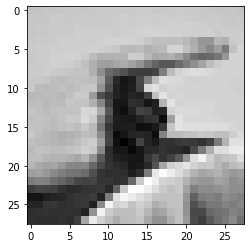

In [3]:
plt.imshow(x_test[0], cmap='gray')

인공지능 모델이 이 이미지를 입력받았을 때, 해당하는 알파벳을 출력할 수 있도록 만드는 것이 목표입니다. 우리는 y_test 라벨값도 가지고 있어서 바로 확인은 할 수 있으나, 모델 학습 시에는 사용이 되지 않으며, 시험 평가할 때만 사용됩니다.

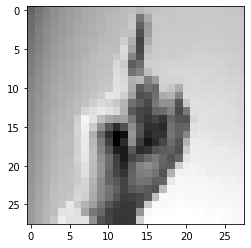

In [4]:
plt.imshow(x_train[0], cmap='gray')

In [5]:
print(y_test[0])

6


모델 학습에 용이하도록 다음과 같이 데이터 전처리를 수행합니다.

*   데이터 전처리
    * 3차원(샘플수, 세로, 가로)를 2차원(샘플수, 벡터수)으로 변경
    * 정수를 실수로 변경
    * 0 ~ 255 사이의 수치를 0.0 ~ 1.0 사이로 정규화 수행
*   라벨 전처리
    * 0 ~ 9 라벨에 대한 원핫인코딩 수행 



In [6]:
x_train_in = x_train.reshape(27455, 28, 28, 1).astype('float32') / 255.0
x_test_in = x_test.reshape(7172, 28, 28, 1).astype('float32') / 255.0
y_train_in = to_categorical(y_train)
y_test_in = to_categorical(y_test)

In [7]:
print(x_train_in[1])

[[[0.60784316]
  [0.6156863 ]
  [0.6117647 ]
  [0.6117647 ]
  [0.6117647 ]
  [0.6156863 ]
  [0.6117647 ]
  [0.61960787]
  [0.61960787]
  [0.6156863 ]
  [0.61960787]
  [0.6117647 ]
  [0.6039216 ]
  [0.6039216 ]
  [0.6       ]
  [0.59607846]
  [0.5921569 ]
  [0.58431375]
  [0.58431375]
  [0.5803922 ]
  [0.5764706 ]
  [0.57254905]
  [0.5647059 ]
  [0.5568628 ]
  [0.56078434]
  [0.5411765 ]
  [0.36078432]
  [0.42352942]]

 [[0.61960787]
  [0.62352943]
  [0.62352943]
  [0.62352943]
  [0.627451  ]
  [0.627451  ]
  [0.627451  ]
  [0.627451  ]
  [0.627451  ]
  [0.627451  ]
  [0.627451  ]
  [0.62352943]
  [0.61960787]
  [0.6156863 ]
  [0.60784316]
  [0.6039216 ]
  [0.6       ]
  [0.59607846]
  [0.5921569 ]
  [0.5882353 ]
  [0.58431375]
  [0.58431375]
  [0.5764706 ]
  [0.5764706 ]
  [0.57254905]
  [0.5568628 ]
  [0.45490196]
  [0.56078434]]

 [[0.6313726 ]
  [0.6313726 ]
  [0.6313726 ]
  [0.6313726 ]
  [0.63529414]
  [0.6313726 ]
  [0.63529414]
  [0.63529414]
  [0.63529414]
  [0.63529414]
  [0.6

모델은 다음과 같이 구성하였습니다.

* 입력: 1차원의 784개 벡터
* 출력: 10개 벡터
* 출력층의 활성화 함수: 소프트맥스
* 손실함수: categorical_crossentropy
* 최적화기: adam
* 평가 메트릭: accuracy


In [8]:
x_train.shape

(27455, 28, 28)

In [31]:
model = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(28,28,1), activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (4,4), padding='same', activation='relu'),
    Conv2D(32, (4,4), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(25, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

모델 네트워크 아키텍처 구성을 그려보겠습니다.

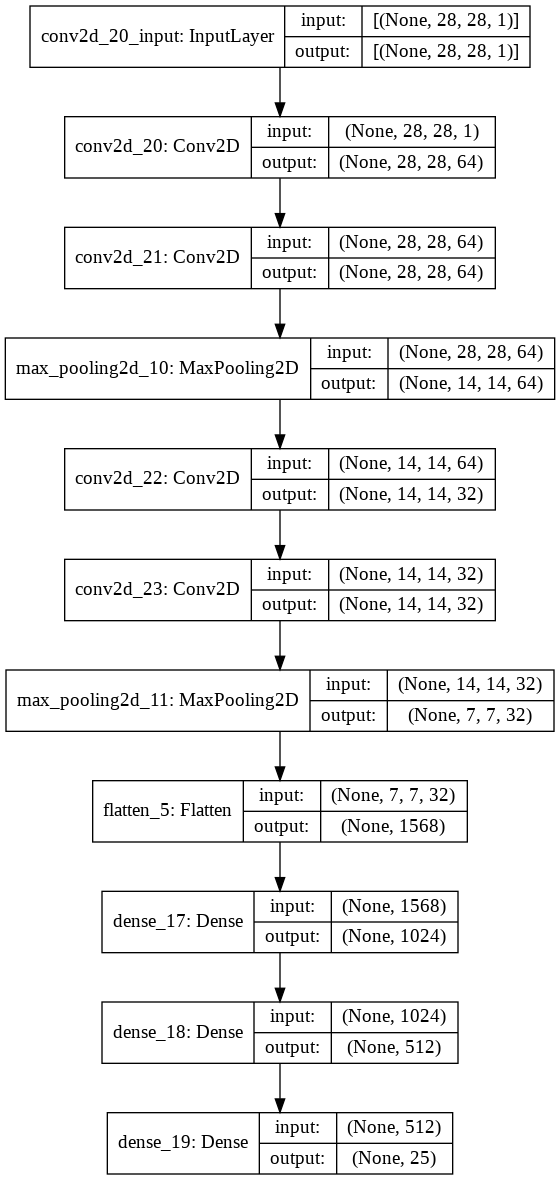

In [32]:
plot_model(model, show_shapes=True)

모델을 학습시킬 때, validation_split 옵션을 두면 훈련셋 일부를 검증셋으로 설정할 수 있습니다. 0.2로 설정할 경우, 전체 훈련셋에서 20%를 검증셋, 나머지를 훈련셋으로 구성하여 학습합니다.

학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 오버피팅 여부를 한 눈에 확인할 수 있습니다.

오버피팅이 10 에포크 이전에 발생했더라도 100 에포크까지 학습을 시켰으므로 현재 모델은 오버피팅이 되어 있는 상태입니다. 오버피팅이 되지 않은 모델을 확보하기 위해는 아래 세 가지 방법을 사용할 수 있습니다. 

1. 오버피팅이 되는 에포크를 확인하였다면, 오버피팅 전의 에포크 만큼 모델을 학습시킵니다.
2. 콜백함수를 사용하여, 오버피팅이 감지되면 조기 중단을 시키도록 합니다.
3. 콜백함수를 사용하여, 매 에포크마다 검증셋의 손실값을 체크한 후, 이전 손실값보다 낮은 경우 모델을 파일로 저장합니다. 즉 학습 종료가 되면, 파일에 저장된 모델은 손실값이 가장 낮을 때의 가중치를 가지고 있습니다.

1번 방법은 두 번 학습을 시켜야하고, 2번 방법은 더 학습이 가능했음에도 설정된 오버피팅 감지 조건에 의해 조기 중단이 될 수도 있으므로, 이후 실습에서는 주로 3번 방법을 사용하도록 하겠습니다.

모델 정의부터 컴파일, 콜백함수 정의, 모델 학습까지의 코드는 아래와 같습니다. 다음부터는 두 번 학습할 필요없이 아래 코드로 한 번만 수행합니다.

In [38]:


checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train_in, y_train_in, 
                 validation_split=0.2, 
                 batch_size=16,
                 epochs=50,  
                 callbacks=[checkpoint_callback])

Epoch 1/50
1373/1373 [==============================] - 15s 11ms/step - loss: 1.2711e-08 - accuracy: 1.0000 - val_loss: 5.2347e-07 - val_accuracy: 1.0000
Epoch 2/50
1373/1373 [==============================] - 14s 10ms/step - loss: 6.4261e-09 - accuracy: 1.0000 - val_loss: 2.6668e-07 - val_accuracy: 1.0000
Epoch 3/50
1373/1373 [==============================] - 14s 10ms/step - loss: 3.3053e-09 - accuracy: 1.0000 - val_loss: 2.0149e-07 - val_accuracy: 1.0000
Epoch 4/50
1373/1373 [==============================] - 14s 10ms/step - loss: 1.6771e-09 - accuracy: 1.0000 - val_loss: 8.0686e-08 - val_accuracy: 1.0000
Epoch 5/50
1373/1373 [==============================] - 14s 10ms/step - loss: 9.0639e-10 - accuracy: 1.0000 - val_loss: 6.3149e-08 - val_accuracy: 1.0000
Epoch 6/50
1373/1373 [==============================] - 14s 10ms/step - loss: 4.4505e-10 - accuracy: 1.0000 - val_loss: 3.9033e-08 - val_accuracy: 1.0000
Epoch 7/50
1373/1373 [==============================] - 14s 10ms/step - loss

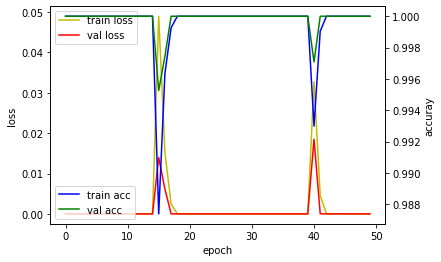

In [40]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

이로서 현재 학습 과정 중 가장 낮은 검증셋의 손실값을 가진 모델이 "best_model.h5" 파일로 저장되었습니다.

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [41]:
model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test_in, y_test_in)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

225/225 [==============================] - 2s 7ms/step - loss: 0.3119 - accuracy: 0.9617
Test accuracy 0.9616564512252808
Test loss 0.311914324760437


또한 시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 출력이 10개 클래스에 해당하는 벡터이므로, 분류한 클래스 정보를 얻기 위해 가장 높은 값을 가진 인덱스 값을 가지고 옵니다. 이 인덱스가 클래스를 의미하며, 이 값을 파일로 저장합니다.

In [43]:
y_pred = model.predict(x_test_in)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred.csv', y_pred, fmt='%d')